# Use Hugging Face's Tensorflow 2 transformer models for NQ

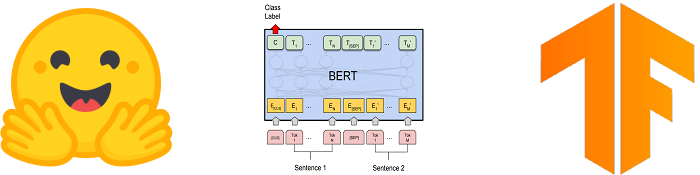

## Introduction
This kernel demonstrates how to use Hugging Face's [transformers](https://github.com/huggingface/transformers) package, more precisely, theier `Tensorflow 2` models, for this competition.

## Motivations

* Give my first contribution on Kaggle.
* To learn and work on some things new.
* Provide an easy to read/use training kernel for this competition.
* (The most important) I want to have your feedbacks, and solutions to some of my questions, so we can improve this kernel!

## Features
I tried my efforts to make the following things work:

* batch accumulation.
* Adam optimizer with weight decay and make it work with learning rate decay. (I take [AdamW](https://github.com/tensorflow/addons/blob/master/tensorflow_addons/optimizers/weight_decay_optimizers.py#L340) class from `Tensorflow Addons` with some modification. See `adamw_optimizer.py`)
* Custom learning rate schedule as close as to the original google Bert code.
* Easy to choose different model configurations.

## Important Notes

* I didn't use the pre-trained model from starter kernel.
* I didn't check (yet) the LB scores for the checkpoints I provided.
* No code for inference/submission in this kernel. (I will work on a separate kernel.)
* The flag `model_name` is default to `distilbert-base-uncased-distilled-squad`. The `batch_size` and `batch_accumulation_size` is however defaut to `10`. It's your own responsibility to make sure there is no OOM when you change these parameters.
* In the training loop, if the training is on `Kaggle`, then it stops after `8 hours 45 minutes` so we can still have a saved checkpoint.
* This kerenl is not optimalized for training. (See next section.)
* The checkpoints provided in [nq-competition](https://www.kaggle.com/yihdarshieh/nq-competition) (as the value of `NQ_DIR` below) are trained by myself without any effort on choosing the hyperparameters.
* After you have your new trained checkpoints (or if you create your own .tfrecord file), when you want to use them for resuming training, you have to set your own value for `MY_OWN_NQ_DIR`, which should contain your own checkpoints/.tfrecord file.
* This kernel is not written for using TPU.

## Checkpoints, Batch size and Training time

In the following table, the model configurations are:

* `distilled bert`: distilbert-base-uncased-distilled-squad
* `bert base`: bert-base-uncased
* `bert large`: bert-large-uncased-whole-word-masking-finetuned-squad

Here is the summary of the checkpoints I provided (no `bert large`, it will eat up my GUP quota. Probably I will provide one after training on GCP).

| model          | batch size | accumulation size | effective batch size | num. updates | training time | epochs | time / epoch |
|----------------|------------|-------------------|----------------------|--------------|---------------|--------|--------------|
| distilled bert | 25         | 4                 | 100                  | 9893         | 30823 s       | 2      | 4.28 h       | 
| bert base      | 10         | 10                | 100                  | 4500         | 32226 s       | 0.909  | 9.84 h       |
| bert large     | 2          | 50                | 100                  | n/a          | n/a           | n/a    | 37.78 h      | 
|                |            |                   |                      |              |               |        |              |

#### Remark:
For `distilled bert`, I didn't test with `train_batch_size=10` and `batch_accumulation_size=10` for `epochs=2`. It's possible that this will take more time than the time indicated above.

## A screenshot of training progress

In training loop, I print the losses and accuracies every `100` effective batch, here `1 effective batch = batch_size * accumulation_size`. It includes those for `start_pos (loss_S, acc_S)`, `end_pos (loss_E, acc_E)` and `answer_type (loss_A, acc_A)`. The following screenshot is however taken from a training where the result is printed every effective batch.

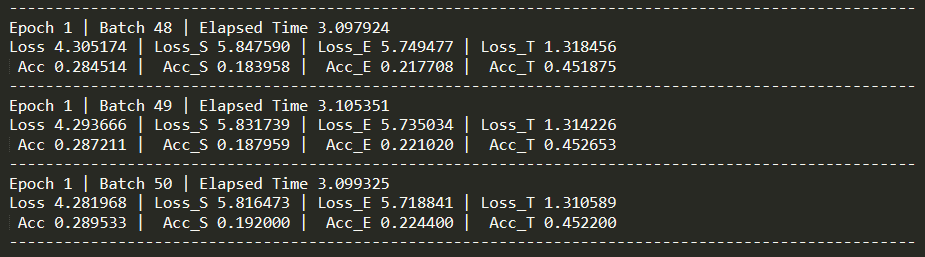

#### Remark:

In the trainin progress, `batch n` means `effective batch n`.

## TODO - Some contribution wanted!

* This kernel is only for training. I will add the prediction/submission parts as soon as possible (In a separate kernel.)
* The batch accumulation code seems work fine, but not memory/speed efficient. In particular, I can't get rid of the following warning.
> UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
* Maybe TPU support, not very sure. However, see the 3rd link in the `Reference` section.

## Things tried but not working - Solution wanted!

I tried to use mixed precision for training, but I couldn't make it work.

* Using [tf.keras.mixed_precision.experimental.Policy](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/experimental/Policy) for mixed precision training causes error when loading pretrained models. (` input #1(zero-based) was expected to be a half tensor but is a float tensor [Op:AddV2] name: tf_bert_model_1/bert/embeddings/add/`.)
* Using [tf.config.optimizer.set_experimental_options](https://www.tensorflow.org/api_docs/python/tf/config/optimizer/set_experimental_options) doesn't make tranining faster. Probably this is designed only for compiled model??

## Disclamation
* I am not a part of Hugging Face. I choose to use `transformers` package because I found it's easier to use and to extend, so I can focus on other parts of this notebook.
* I take no responsibility for any (potential) error in this kernel and in the dataset `nq-competition`. (I would appreciate any feedback.)
* I take no credit of any file (with/without my own modifications) containing in `nq-compeittion`.

## References

* [Transformer model for language understanding (colab tutorial)](https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/r2/tutorials/text/transformer.ipynb#scrollTo=KiVIjF8EJzAx) - Official Tensorflow tutorial on transformer model
* [淺談神經機器翻譯 & 用 Transformer 與 TensorFlow 2 英翻中](https://leemeng.tw/neural-machine-translation-with-transformer-and-tensorflow2.html) - An annotated chinese tutorial based on the above one
* [Sequence classification with Transformers & Strategy](https://colab.research.google.com/drive/1yWaLpCWImXZE2fPV0ZYDdWWI8f52__9A#scrollTo=mnhwpzb73KIL) - Hugging Face's tutorial on how to use their TF 2.0 models on TPU
* [Hugging Face: State-of-the-Art Natural Language Processing in ten lines of TensorFlow 2.0 ](https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html) - Hugging Face's post on Tensorflow blog

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import sys
import json
import tensorflow as tf # Yes, we are going to play with Tensorflow 2!
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import absl # For using flags without tf.compat.v1.flags.Flag
import datetime

In [ ]:
# Input data files are available in the "../input/" directory.
IS_KAGGLE = True
INPUT_DIR = "/kaggle/input/"

# The original Bert Joint Baseline data.
BERT_JOINT_BASE_DIR = os.path.join(INPUT_DIR, "bertjointbaseline")

# This nq dir contains all files for publicly use.
NQ_DIR = os.path.join(INPUT_DIR, "nq-competition")

# If you want to use your own .tfrecord or new trained checkpoints, you can put them under you own nq dir (`MY_OWN_NQ_DIR`)
# Default to NQ_DIR. You have to change it to the dir containing your own working files.
MY_OWN_NQ_DIR = NQ_DIR

# For local usage.
if not os.path.isdir(INPUT_DIR):
    IS_KAGGLE = False
    INPUT_DIR = "./"
    NQ_DIR = "./"
    MY_OWN_NQ_DIR = "./"

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

INPUT_DIR

In [ ]:
# NQ_DIR contains some packages / modules
sys.path.append(NQ_DIR)
sys.path.append(os.path.join(NQ_DIR, "transformers"))

from nq_flags import DEFAULT_FLAGS as FLAGS
from nq_flags import del_all_flags
from nq_dataset_utils import *

import sacremoses as sm
import transformers
from adamw_optimizer import AdamW

## Hugging Face pretrained Bert model names

* Model names taken from: https://github.com/huggingface/transformers/blob/master/transformers/
* To use the models, we have to get configuration, vocab, and model files. These files have to be renamed to `config.json`, `vocab.txt` and `tf_model.h5`.
* Under the above transformers web page, you can find links to
    * Models: see links in modeling_bert.py / modeling_distilbert.py
    * Configurations, see configuration_bert.py / configuration_distilbert.py
    * Vocabs, see tokenization_bert.py / tokenization_distilbert.py

#### Important

We are using a particular dataset `nq-train.tfrecords-00000-of-00001`, which is created with a customized bert vocabulary `vocab-nq` and it is uncased. If you want to use cased bert model, you have to regenerate the training dataset.

In [ ]:
PRETRAINED_MODELS = {
    "BERT": [
        'bert-base-uncased',
        'bert-large-uncased',
        'bert-base-cased',
        'bert-large-cased',
        'bert-base-multilingual-uncased',
        'bert-base-multilingual-cased',
        'bert-base-chinese',
        'bert-base-german-cased',
        'bert-large-uncased-whole-word-masking',
        'bert-large-cased-whole-word-masking',
        'bert-large-uncased-whole-word-masking-finetuned-squad',
        'bert-large-cased-whole-word-masking-finetuned-squad',
        'bert-base-cased-finetuned-mrpc'
    ],
    "DISTILBERT": [
        'distilbert-base-uncased',
        'distilbert-base-uncased-distilled-squad'
    ]
}

## Abseil Flags - Datasets

`Tensorflow 2` no longer supports `flags`, and it is in favor of the now open-source `absl-py`.

I keep using (Abseil) flags in this kernel for making definitions clear, but my way of using it is not for command-line use. At some point later, `FLAGS.mark_as_parsed()` is called.

This section contains flags about the characteristics of the datasets.

In [ ]:
flags = absl.flags
del_all_flags(flags.FLAGS)

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

vocab_file = os.path.join(NQ_DIR, "vocab-nq.txt")

flags.DEFINE_string("vocab_file", vocab_file,
                    "The vocabulary file that the BERT model was trained on.")

flags.DEFINE_integer(
    "max_seq_length_for_training", 512,
    "The maximum total input sequence length after WordPiece tokenization for training examples. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "max_seq_length", 512,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "doc_stride", 128,
    "When splitting up a long document into chunks, how much stride to "
    "take between chunks.")

flags.DEFINE_float(
    "include_unknowns_for_training", 0.02,
    "If positive, for converting training dataset, probability of including answers of type `UNKNOWN`.")

flags.DEFINE_float(
    "include_unknowns", -1.0,
    "If positive, probability of including answers of type `UNKNOWN`.")

flags.DEFINE_boolean(
    "skip_nested_contexts", True,
    "Completely ignore context that are not top level nodes in the page.")

flags.DEFINE_integer("max_contexts", 48,
                     "Maximum number of contexts to output for an example.")

flags.DEFINE_integer(
    "max_position", 50,
    "Maximum context position for which to generate special tokens.")

flags.DEFINE_integer(
    "max_query_length", 64,
    "The maximum number of tokens for the question. Questions longer than "
    "this will be truncated to this length.")

## Abseil Flags - Hyperparameters and file paths

In [ ]:
if os.path.isfile(os.path.join(MY_OWN_NQ_DIR, "nq_train.tfrecord")):
    TRAIN_TF_RECORD = os.path.join(MY_OWN_NQ_DIR, "nq_train.tfrecord")
elif os.path.isfile(os.path.join(MY_OWN_NQ_DIR, "nq-train.tfrecords-00000-of-00001")):
    TRAIN_TF_RECORD = os.path.join(MY_OWN_NQ_DIR, "nq-train.tfrecords-00000-of-00001")
else:
    TRAIN_TF_RECORD = os.path.join(BERT_JOINT_BASE_DIR, "nq-train.tfrecords-00000-of-00001")
    
flags.DEFINE_string("train_tf_record", TRAIN_TF_RECORD,
                    "Precomputed tf records for training dataset.")

flags.DEFINE_string("valid_tf_record", os.path.join(NQ_DIR, "nq_valid.tfrecord"),
                    "Precomputed tf records for validation dataset.")

flags.DEFINE_string("valid_small_tf_record", os.path.join(NQ_DIR, "nq_valid_small.tfrecord"),
                    "Precomputed tf records for a smaller validation dataset.")

flags.DEFINE_string("valid_tf_record_with_labels", "nq_valid_with_labels.tfrecord",
                    "Precomputed tf records for validation dataset with labels.")

flags.DEFINE_string("valid_small_tf_record_with_labels", "nq_valid_small_with_labels.tfrecord",
                    "Precomputed tf records for a smaller validation dataset with labels.")

# This file should be generated when the kernel is running using the provided test dataset!
flags.DEFINE_string("test_tf_record", "nq_test.tfrecord",
                    "Precomputed tf records for test dataset.")

flags.DEFINE_bool("do_train", False, "Whether to run training dataset.")

flags.DEFINE_bool("do_valid", False, "Whether to run validation dataset.")

flags.DEFINE_bool("smaller_valid_dataset", True, "Whether to use the smaller validation dataset")

flags.DEFINE_bool("do_predict", True, "Whether to run test dataset.")

flags.DEFINE_string(
    "validation_prediction_output_file", "validatioin_predictions.json",
    "Where to print predictions for validation dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "validation_small_prediction_output_file", "validatioin_small_predictions.json",
    "Where to print predictions for validation dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "prediction_output_file", "predictions.json",
    "Where to print predictions for test dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "input_checkpoint_dir", os.path.join(MY_OWN_NQ_DIR, "checkpoints"),
    "The root directory that contains checkpoints to be loaded of all trained models.")

flags.DEFINE_string(
    "output_checkpoint_dir", "checkpoints",
    "The output directory where the model checkpoints will be written to.")

# If you want to use other Hugging Face's models, change this to `MY_OWN_NQ_DIR` and put the downloaded models at the right place.
flags.DEFINE_string("model_dir", NQ_DIR, "Root dir of all Hugging Face's models")

flags.DEFINE_string("model_name", "distilbert-base-uncased-distilled-squad", "Name of Hugging Face's model to use.")
# flags.DEFINE_string("model_name", "bert-base-uncased", "Name of Hugging Face's model to use.")
# flags.DEFINE_string("model_name", "bert-large-uncased-whole-word-masking-finetuned-squad", "Name of Hugging Face's model to use.")

flags.DEFINE_integer("epochs", 1, "Total epochs for training.")

flags.DEFINE_integer("train_batch_size", 10, "Batch size for training.")

flags.DEFINE_integer("shuffle_buffer_size", 100000, "Shuffle buffer size for training.")

flags.DEFINE_integer("batch_accumulation_size", 50, "Number of batches to accumulate gradient before applying optimization.")

flags.DEFINE_float("init_learning_rate", 5e-5, "The initial learning rate for AdamW optimizer.")

flags.DEFINE_bool("cyclic_learning_rate", True, "If to use cyclic learning rate.")

flags.DEFINE_float("init_weight_decay_rate", 0.01, "The initial weight decay rate for AdamW optimizer.")

flags.DEFINE_integer("num_warmup_steps", 0, "Number of training steps to perform linear learning rate warmup.")

flags.DEFINE_integer("num_train_examples", None, "Number of precomputed training steps in 1 epoch.")

flags.DEFINE_integer("predict_batch_size", 25, "Batch size for predictions.")

# ----------------------------------------------------------------------------------------
flags.DEFINE_integer(
    "n_best_size", 10,
    "The total number of n-best predictions to generate in the "
    "nbest_predictions.json output file.")

flags.DEFINE_integer(
    "max_answer_length", 30,
    "The maximum length of an answer that can be generated. This is needed "
    "because the start and end predictions are not conditioned on one another.")

flags.DEFINE_string(
    "validation_predict_file", os.path.join(NQ_DIR, "simplified-nq-dev.jsonl"),
    "")

flags.DEFINE_string(
    "validation_predict_file_small", os.path.join(NQ_DIR, "simplified-nq-dev-small.jsonl"),
    "")

# ----------------------------------------------------------------------------------------
## Special flags - do not change

if IS_KAGGLE: 
    flags.DEFINE_string(
        "predict_file", "/kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl",
        "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
else:
    flags.DEFINE_string(
        "predict_file", os.path.join(NQ_DIR, "simplified-nq-test.jsonl"),
        "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
    
if IS_KAGGLE: 
    flags.DEFINE_string(
        "sample_submission_csv", "/kaggle/input/tensorflow2-question-answering/sample_submission.csv",
        "path to sample submission csv file.")
else:
    flags.DEFINE_string(
        "sample_submission_csv", os.path.join(NQ_DIR, "sample_submission.csv"),
        "path to sample submission csv file.")    
    
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

# Make the default flags as parsed flags
FLAGS.mark_as_parsed()

In [ ]:
IS_SUBMITTING = False

test_answers_df = pd.read_csv(FLAGS.sample_submission_csv)

if IS_KAGGLE and len(test_answers_df) != 692:
    IS_SUBMITTING = True
    FLAGS.do_train = False
    FLAGS.do_valid = False
    FLAGS.do_predict = True

In [ ]:
print(len(test_answers_df))
print(IS_SUBMITTING)
print(FLAGS.do_train)
print(FLAGS.do_valid)
print(FLAGS.do_predict)

In [ ]:
NB_ANSWER_TYPES = 5

## Get Datasets from TF Record files

A method to get datasets from tf_record_file. See next section for the usage.[](http://)

In [ ]:
def get_dataset(tf_record_file, seq_length, batch_size=1, shuffle_buffer_size=0, is_training=False):

    if is_training:
        features = {
            "unique_ids": tf.io.FixedLenFeature([], tf.int64),
            "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
            "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "start_positions": tf.io.FixedLenFeature([], tf.int64),
            "end_positions": tf.io.FixedLenFeature([], tf.int64),
            "answer_types": tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        features = {
            "unique_ids": tf.io.FixedLenFeature([], tf.int64),
            "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
            "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64)
        }        

    # Taken from the TensorFlow models repository: https://github.com/tensorflow/models/blob/befbe0f9fe02d6bc1efb1c462689d069dae23af1/official/nlp/bert/input_pipeline.py#L24
    def decode_record(record, features):
        """Decodes a record to a TensorFlow example."""
        example = tf.io.parse_single_example(record, features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.cast(t, tf.int32)
            example[name] = t
        return example

    def select_data_from_record(record):
        
        x = {
            'unique_ids': record['unique_ids'],
            'input_ids': record['input_ids'],
            'input_mask': record['input_mask'],
            'segment_ids': record['segment_ids']
        }

        if is_training:
            y = {
                'start_positions': record['start_positions'],
                'end_positions': record['end_positions'],
                'answer_types': record['answer_types']
            }

            return (x, y)
        
        return x

    dataset = tf.data.TFRecordDataset(tf_record_file)
    
    dataset = dataset.map(lambda record: decode_record(record, features))
    dataset = dataset.map(select_data_from_record)
    
    if shuffle_buffer_size > 0:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size)
    
    return dataset

## Set num_train_examples if FLAGS.num_train_examples is None

In [ ]:
if FLAGS.num_train_examples is None:
    FLAGS.num_train_examples = 494670

## Check a small batch in training / validation dataset

In [ ]:
valid_tf_record = FLAGS.valid_tf_record
if FLAGS.smaller_valid_dataset:
    valid_tf_record = FLAGS.valid_small_tf_record
    
valid_tf_record_with_labels = FLAGS.valid_tf_record_with_labels
if FLAGS.smaller_valid_dataset:
    valid_tf_record_with_labels = FLAGS.valid_small_tf_record_with_labels

train_dataset = get_dataset(FLAGS.train_tf_record,
                    seq_length=FLAGS.max_seq_length_for_training,
                    batch_size=2,
                    shuffle_buffer_size=FLAGS.shuffle_buffer_size,
                    is_training=True
                )    

validation_dataset = get_dataset(os.path.join(NQ_DIR, valid_tf_record),
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=False
                     )

validation_dataset_with_labels = get_dataset(os.path.join(NQ_DIR, valid_tf_record_with_labels),
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=True
                     )

test_dataset = get_dataset(FLAGS.test_tf_record,
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=False
                     )

# Can't use next(train_dataset)!
features, targets = next(iter(train_dataset))
print(features)
print(targets)

features = next(iter(validation_dataset))
print(features)

features, labels = next(iter(validation_dataset_with_labels))
print(features)

# features = next(iter(test_dataset))
# print(features)

## Demo of using Hugging Face Tensorflow 2.0 models

In [ ]:
from transformers import TFBertModel
from transformers import TFBertMainLayer, TFBertPreTrainedModel
from transformers.modeling_tf_utils import get_initializer

class TFBertForNQDemo(TFBertPreTrainedModel):
    
    def __init__(self, config, *inputs, **kwargs):
        
        super(TFBertForNQDemo, self).__init__(config, *inputs, **kwargs)

        self.bert = TFBertMainLayer(config, name='bert')
        
        self.seq_output_dropout = tf.keras.layers.Dropout(kwargs.get('seq_output_dropout_prob', 0.05))
        self.pooled_output_dropout = tf.keras.layers.Dropout(kwargs.get('pooled_output_dropout_prob', 0.05))
        
        self.pos_classifier = tf.keras.layers.Dense(2,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='pos_classifier')
        
        self.answer_type_classifier = tf.keras.layers.Dense(NB_ANSWER_TYPES,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='answer_type_classifier')         
        
    def call(self, inputs, **kwargs):
        
        bert_outputs = self.bert(inputs, **kwargs)

        # sequence / [CLS] outputs from original bert
        sequence_output, pooled_output = bert_outputs[0], bert_outputs[1]  # shape = (batch_size, seq_len, hidden_dim) / (batch_size, hidden_dim)

        # dropout
        sequence_output = self.seq_output_dropout(sequence_output, training=kwargs.get('training', False))
        pooled_output = self.pooled_output_dropout(pooled_output, training=kwargs.get('training', False))
        
        pos_logits = self.pos_classifier(sequence_output)  # shape = (batch_size, seq_len, 2)
        start_pos_logits = pos_logits[:, :, 0]  # shape = (batch_size, seq_len)
        end_pos_logits = pos_logits[:, :, 1]  # shape = (batch_size, seq_len)
        
        answer_type_logits = self.answer_type_classifier(pooled_output)  # shape = (batch_size, NB_ANSWER_TYPES)

        outputs = (start_pos_logits, end_pos_logits, answer_type_logits)

        return outputs  # logits

## Try the demo model

In [ ]:
from transformers import BertTokenizer

pretrained_weights = os.path.join(NQ_DIR, "bert-base-uncased")

bert_tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

bert_barebone = TFBertModel.from_pretrained(pretrained_weights)
bert_for_nq = TFBertForNQDemo.from_pretrained(pretrained_weights)

input_ids = tf.constant(bert_tokenizer.encode("My cat is so cute!"))[None, :]  # Batch size 1
input_masks = tf.constant(0, shape=input_ids.shape)
segment_ids = tf.constant(0, shape=input_ids.shape)

# Actual inputs to model's `call()` method.
inputs = (input_ids, input_masks, segment_ids)

# Outputs from `bert_barebone`
outputs = bert_barebone(inputs)
last_hidden_states = outputs[0]
print(last_hidden_states.shape)

# Outputs from `bert_for_nq`
outputs = bert_for_nq(inputs)
(start_pos_logits, end_pos_logits, answer_type_logits) = outputs
print(start_pos_logits.shape)
print(end_pos_logits.shape)
print(answer_type_logits.shape)

len(bert_for_nq.trainable_variables)

## An interface  for NQ models

In [ ]:
from transformers import BertTokenizer
from transformers import TFBertModel, TFDistilBertModel
from transformers import TFBertMainLayer, TFDistilBertMainLayer, TFBertPreTrainedModel, TFDistilBertPreTrainedModel
from transformers.modeling_tf_utils import get_initializer

class TFNQModel:
    
    def __init__(self, config, *inputs, **kwargs):
        """
        
        Subclasses of this class are different in self.backend,
        which should be a model that outputs a tensor of shape (batch_size, hidden_dim), and the
        `backend_call()` method.
        
        We will use Hugging Face Bert/DistilBert as backend in this notebook.
        """

        self.backend = None
        
        self.seq_output_dropout = tf.keras.layers.Dropout(kwargs.get('seq_output_dropout_prob', 0.05))
        self.pooled_output_dropout = tf.keras.layers.Dropout(kwargs.get('pooled_output_dropout_prob', 0.05))
        
        self.pos_classifier = tf.keras.layers.Dense(2,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='pos_classifier')       

        self.answer_type_classifier = tf.keras.layers.Dense(NB_ANSWER_TYPES,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='answer_type_classifier')         
                
    def backend_call(self, inputs, **kwargs):
        """This method should be implemented by subclasses.
           
           The implementation should take into account the (somehow) different input formats of Hugging Face's
           models.
           
           For example, the `TFDistilBert` model, unlike `Bert` model, doesn't have segment_id as input.
           
           Then it calls `self.backend_call()` to get the outputs from Bert's model, which is used in self.call().
        """
        
        raise NotImplementedError

    
    def call(self, inputs, **kwargs):
        
        # sequence / [CLS] outputs from original bert
        sequence_output, pooled_output = self.backend_call(inputs, **kwargs)  # shape = (batch_size, seq_len, hidden_dim) / (batch_size, hidden_dim)
        
        # dropout
        sequence_output = self.seq_output_dropout(sequence_output, training=kwargs.get('training', False))
        pooled_output = self.pooled_output_dropout(pooled_output, training=kwargs.get('training', False))
        
        pos_logits = self.pos_classifier(sequence_output)  # shape = (batch_size, seq_len, 2)
        start_pos_logits = pos_logits[:, :, 0]  # shape = (batch_size, seq_len)
        end_pos_logits = pos_logits[:, :, 1]  # shape = (batch_size, seq_len)
        
        answer_type_logits = self.answer_type_classifier(pooled_output)  # shape = (batch_size, NB_ANSWER_TYPES)

        outputs = (start_pos_logits, end_pos_logits, answer_type_logits)

        return outputs  # logits
    
    
class TFBertForNQ(TFNQModel, TFBertPreTrainedModel):
    
    def __init__(self, config, *inputs, **kwargs):
        
        TFBertPreTrainedModel.__init__(self, config, *inputs, **kwargs)  # explicit calls without super
        TFNQModel.__init__(self, config)

        self.bert = TFBertMainLayer(config, name='bert')
        
    def backend_call(self, inputs, **kwargs):
        
        outputs = self.bert(inputs, **kwargs)
        sequence_output, pooled_output = outputs[0], outputs[1]  # shape = (batch_size, seq_len, hidden_dim) / (batch_size, hidden_dim)
        
        return sequence_output, pooled_output
        
class TFDistilBertForNQ(TFNQModel, TFDistilBertPreTrainedModel):
    
    def __init__(self, config, *inputs, **kwargs):
        
        TFDistilBertPreTrainedModel.__init__(self, config, *inputs, **kwargs)  # explicit calls without super
        TFNQModel.__init__(self, config)

        self.backend = TFDistilBertMainLayer(config, name="distilbert")
        
    def backend_call(self, inputs, **kwargs):
        
        if isinstance(inputs, tuple):
            # Distil bert has no segment_id (i.e. `token_type_ids`)
            inputs = inputs[:2]
        else:
            inputs = inputs
        
        outputs = self.backend(inputs, **kwargs)
        
        # TFDistilBertModel's output[0] is of shape (batch_size, sequence_length, hidden_size)
        # We take only for the [CLS].
        
        sequence_output = outputs[0]  # shape = (batch_size, seq_len, hidden_dim)
        pooled_output = sequence_output[:, 0, :]  # shape = (batch_size, hidden_dim)
        
        return sequence_output, pooled_output
    
    
model_mapping = {
    "bert": TFBertForNQ,
    "distilbert": TFDistilBertForNQ
}


def get_pretrained_model(model_name):
    
    pretrained_path = os.path.join(FLAGS.model_dir, model_name)
    
    tokenizer = BertTokenizer.from_pretrained(pretrained_path)
    
    model_type = model_name.split("-")[0]
    if model_type not in model_mapping:
        raise ValueError("Model definition not found.")
    
    model_class = model_mapping[model_type]
    model = model_class.from_pretrained(pretrained_path)
    
    return tokenizer, model

## Try Bert / DistillBert models for NQ

In [ ]:
bert_tokenizer, bert_for_nq = get_pretrained_model('bert-base-uncased')
_, distil_bert_for_nq = get_pretrained_model('distilbert-base-uncased-distilled-squad')

input_ids = tf.constant(bert_tokenizer.encode("Hello, my dog is cute"))[None, :]  # Batch size 1
input_masks = tf.constant(0, shape=input_ids.shape)
segment_ids = tf.constant(0, shape=input_ids.shape)

# Actual inputs to model
inputs = (input_ids, input_masks, segment_ids)

# Outputs from bert_for_nq using backend_call()
outputs = bert_for_nq(inputs)
(start_pos_logits, end_pos_logits, answer_type_logits) = outputs
print(start_pos_logits.shape)
print(end_pos_logits.shape)
print(answer_type_logits.shape)
# print(start_pos_binary_probs.shape)
# print(end_pos_binary_probs.shape)

len(bert_for_nq.trainable_variables)

# Outputs from distil_bert_for_nq using backend_call()
outputs = distil_bert_for_nq(inputs)
(start_pos_logits, end_pos_logits, answer_type_logits) = outputs
print(start_pos_logits.shape)
print(end_pos_logits.shape)
print(answer_type_logits.shape)
# print(start_pos_binary_probs.shape)
# print(end_pos_binary_probs.shape)

len(distil_bert_for_nq.trainable_variables)

## Choose the model to use

Get a new model, determined by `FLAGS.model_name` (for example, `bert-base-uncased`), and print its trainable variables.

In [ ]:
bert_tokenizer, bert_nq = get_pretrained_model(FLAGS.model_name)

if not IS_KAGGLE:
    bert_nq.trainable_variables

## Metrics

In [ ]:
def get_metrics(name):

    loss = tf.keras.metrics.Mean(name=f'{name}_loss')
    loss_start_pos = tf.keras.metrics.Mean(name=f'{name}_loss_start_pos')
    loss_end_pos = tf.keras.metrics.Mean(name=f'{name}_loss_end_pos')
    loss_ans_type = tf.keras.metrics.Mean(name=f'{name}_loss_ans_type')
    
    acc = tf.keras.metrics.SparseCategoricalAccuracy(name=f'{name}_acc')
    acc_start_pos = tf.keras.metrics.SparseCategoricalAccuracy(name=f'{name}_acc_start_pos')
    acc_end_pos = tf.keras.metrics.SparseCategoricalAccuracy(name=f'{name}_acc_end_pos')
    acc_ans_type = tf.keras.metrics.SparseCategoricalAccuracy(name=f'{name}_acc_ans_type')
    
    return loss, loss_start_pos, loss_end_pos, loss_ans_type, acc, acc_start_pos, acc_end_pos, acc_ans_type

train_loss, train_loss_start_pos, train_loss_end_pos, train_loss_ans_type, train_acc, train_acc_start_pos, train_acc_end_pos, train_acc_ans_type = get_metrics("train")
valid_loss, valid_loss_start_pos, valid_loss_end_pos, valid_loss_ans_type, valid_acc, valid_acc_start_pos, valid_acc_end_pos, valid_acc_ans_type = get_metrics("valid")

## Loss function

The loss is not averaged over a batch of training examples. The caller of `loss_function` have to take care of this. The reason of not using average here is that I need the sum of losses to do `batch accumulation`.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(nq_labels, nq_logits):
    
    (start_pos_labels, end_pos_labels, answer_type_labels) = nq_labels
    (start_pos_logits, end_pos_logits, answer_type_logits) = nq_logits
    
    loss_start_pos = loss_object(start_pos_labels, start_pos_logits)
    loss_end_pos = loss_object(end_pos_labels, end_pos_logits)
    loss_ans_type = loss_object(answer_type_labels, answer_type_logits)
    
    loss_start_pos = tf.math.reduce_sum(loss_start_pos)
    loss_end_pos = tf.math.reduce_sum(loss_end_pos)
    loss_ans_type = tf.math.reduce_sum(loss_ans_type)
    
    loss = (loss_start_pos + loss_end_pos + loss_ans_type) / 3.0
    
    return loss, loss_start_pos, loss_end_pos, loss_ans_type

## Custom Learning Schedule

A learning rate sheduler which is close to the original Bert's one: https://github.com/google-research/bert/blob/master/optimization.py#L32.

It supports the following
* warmup stesp (used in the original Bert's optimizer)
* cyclic learning rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.PolynomialDecay):
    
    def __init__(self,
      initial_learning_rate,
      decay_steps,
      end_learning_rate=0.0001,
      power=1.0,
      cycle=False,
      name=None,
      num_warmup_steps=1000):
        
        # Since we have a custom __call__() method, we pass cycle=False when calling `super().__init__()` and
        # in self.__call__(), we simply do `step = step % self.decay_steps` to have cyclic behavior.
        super(CustomSchedule, self).__init__(initial_learning_rate, decay_steps, end_learning_rate, power, cycle=False, name=name)
        
        self.num_warmup_steps = num_warmup_steps
        
        self.cycle = tf.constant(cycle, dtype=tf.bool)
        
    def __call__(self, step):
        """ `step` is actually the step index, starting at 0.
        """
        
        # For cyclic behavior
        step = tf.cond(self.cycle and step >= self.decay_steps, lambda: step % self.decay_steps, lambda: step)
        
        learning_rate = super(CustomSchedule, self).__call__(step)

        # Copy (including the comments) from original bert optimizer with minor change.
        # Ref: https://github.com/google-research/bert/blob/master/optimization.py#L25
        
        # Implements linear warmup: if global_step < num_warmup_steps, the
        # learning rate will be `global_step / num_warmup_steps * init_lr`.
        if self.num_warmup_steps > 0:
            
            steps_int = tf.cast(step, tf.int32)
            warmup_steps_int = tf.constant(self.num_warmup_steps, dtype=tf.int32)

            steps_float = tf.cast(steps_int, tf.float32)
            warmup_steps_float = tf.cast(warmup_steps_int, tf.float32)

            # The first training step has index (`step`) 0.
            # The original code use `steps_float / warmup_steps_float`, which gives `warmup_percent_done` being 0,
            # and causing `learning_rate` = 0, which is undesired.
            # For this reason, we use `(steps_float + 1) / warmup_steps_float`.
            # At `step = warmup_steps_float - 1`, i.e , at the `warmup_steps_float`-th step, 
            #`learning_rate` is `self.initial_learning_rate`.
            warmup_percent_done = (steps_float + 1) / warmup_steps_float
            
            warmup_learning_rate = self.initial_learning_rate * warmup_percent_done

            is_warmup = tf.cast(steps_int < warmup_steps_int, tf.float32)
            learning_rate = ((1.0 - is_warmup) * learning_rate + is_warmup * warmup_learning_rate)
                        
        return learning_rate
    
num_train_steps = int(FLAGS.epochs * FLAGS.num_train_examples / FLAGS.train_batch_size / FLAGS.batch_accumulation_size)

learning_rate = CustomSchedule(
    initial_learning_rate=FLAGS.init_learning_rate,
    decay_steps=num_train_steps,
    end_learning_rate=FLAGS.init_learning_rate,
    power=1.0,
    cycle=FLAGS.cyclic_learning_rate,    
    num_warmup_steps=FLAGS.num_warmup_steps
)

# Normally we want to use this way to plot since it's much fast.
# However, we get the error`The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()`.
# This is due to some bool operations on `step`. So we use the second way (which is slow) to plot.
# (This error also occurs even we use `tf.keras.optimizers.schedules.PolynomialDecay` with `cycle=True`.)

# Get error here.
# plt.plot(learning_rate(tf.range(num_train_steps)))

# This is a workaround to plot, but it's very slow. So we plot the learning rate only when `num_train_steps` is small.
if num_train_steps <= 5000:
    xs = tf.range(2 * num_train_steps)
    ys = [learning_rate(x) for x in xs]
    plt.plot(xs, ys)
    
    plt.ylabel("Learning Rate")
    plt.xlabel("Train Step")
    plt.show()

print(f'num_train_steps: {num_train_steps}')

## Get variables to apply weight decay in AdamW optimizer

In the original Bert's optimizer [AdamWeightDecayOptimizer](https://github.com/google-research/bert/blob/master/optimization.py#L87), it accepts an arguement `exclude_from_weight_decay`, and the list `["LayerNorm", "layer_norm", "bias"]` is passed to it, see [here](https://github.com/google-research/bert/blob/master/optimization.py#L59).

Here we use [tfa.optimizers.AdamW](https://github.com/tensorflow/addons/blob/master/tensorflow_addons/optimizers/weight_decay_optimizers.py#L340), which accepts an arguement `decay_var_list`.

In [ ]:
decay_var_list = []

for i in range(len(bert_nq.trainable_variables)):
    name = bert_nq.trainable_variables[i].name
    if any(x in name for x in ["LayerNorm", "layer_norm", "bias"]):
        decay_var_list.append(name)
        
decay_var_list

## AdamW Optimizer (Weight decay)

The `Adam` optimizer from [tf.kears.optimizers](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/optimizer_v2/adam.py#L32) doesn't support weight decay. But the original Bert's [optimizer](https://github.com/google-research/bert/blob/master/optimization.py#L59) uses weight decay.

There is a `AdamW` class from Tensorflow addons, [tfa.optimizers.AdamW](https://github.com/tensorflow/addons/blob/master/tensorflow_addons/optimizers/weight_decay_optimizers.py#L340). However, it doesn't support [update_with_lr ](https://github.com/google-research/bert/blob/master/optimization.py#L149) as in the original Bert.

There is a [note](https://github.com/tensorflow/addons/blob/master/tensorflow_addons/optimizers/weight_decay_optimizers.py#L362) about how to integrate learing rate decay in `tfa.optimizers.AdamW`:

> when applying a decay to the learning rate, be sure to manually apply the decay to the `weight_decay` as well ...

but I didn't make it work with schedules.

Therefore, we use a modified version. The difference is: Unlike in [DecoupledWeightDecayExtension._decay_weights_op()](https://github.com/tensorflow/addons/blob/master/tensorflow_addons/optimizers/weight_decay_optimizers.py#L154), we compute `weight_decay` as `init_weight_decay * learning_rate`.

This modified version is included in `adamw_optimizer.py` in [nq-competition](https://www.kaggle.com/yihdarshieh/nq-competition) dataset.

#### Note

For performance, we shouldn't re-compute `learning_rate` in modified `DecoupledWeightDecayExtension._decay_weights_op()`.
Instead, we should prepare states to use multiple times as in [apply_state](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/optimizer_v2/optimizer_v2.py#L440) in `tf.keras.optimizers.Optimizer`.
However, it inovles modification of tensorflow code, which I tried to avoid.

In [ ]:
from tensorflow.keras.optimizers import Adam
from adamw_optimizer import AdamW

# The hyperparameters are copied from AdamWeightDecayOptimizer in original bert code.
# (https://github.com/google-research/bert/blob/master/optimization.py#L25)
optimizer = AdamW(weight_decay=FLAGS.init_weight_decay_rate, learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay_var_list=decay_var_list)

## Try to load the latest checkpoint

In [ ]:
checkpoint_path = os.path.join(FLAGS.input_checkpoint_dir, FLAGS.model_name)
ckpt = tf.train.Checkpoint(model=bert_nq)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10000)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print (f'Latest BertNQ checkpoint restored -- Model trained for {last_epoch} epochs')
else:
    print('Checkpoint not found. Train BertNQ from scratch')
    last_epoch = 0
    
    
# Reset saving path, because the FLAGS.input_checkpoint_dir is not writable on Kaggle
print(ckpt_manager._directory)
ckpt_manager._directory = os.path.join(FLAGS.output_checkpoint_dir, FLAGS.model_name)
ckpt_manager._checkpoint_prefix = os.path.join(ckpt_manager._directory, "ckpt")
print(ckpt_manager._directory)

from tensorflow.python.lib.io.file_io import recursive_create_dir
recursive_create_dir(ckpt_manager._directory)

## tf.function and input_signature

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

input_signature = [
        tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
]

## Simple Training Step

No batch accumulation here.

In [ ]:
def get_loss_and_gradients(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels):
    
    nq_inputs = (input_ids, input_masks, segment_ids)
    nq_labels = (start_pos_labels, end_pos_labels, answer_type_labels)

    with tf.GradientTape() as tape:

        nq_logits = bert_nq(nq_inputs, training=True)
        loss, loss_start_pos, loss_end_pos, loss_ans_type = loss_function(nq_labels, nq_logits)
                
    gradients = tape.gradient(loss, bert_nq.trainable_variables)        
        
    (start_pos_logits, end_pos_logits, answer_type_logits) = nq_logits
        
    train_acc.update_state(start_pos_labels, start_pos_logits)
    train_acc.update_state(end_pos_labels, end_pos_logits)
    train_acc.update_state(answer_type_labels, answer_type_logits)

    train_acc_start_pos.update_state(start_pos_labels, start_pos_logits)
    train_acc_end_pos.update_state(end_pos_labels, end_pos_logits)
    train_acc_ans_type.update_state(answer_type_labels, answer_type_logits)
    
    return loss, gradients, loss_start_pos, loss_end_pos, loss_ans_type


@tf.function(input_signature=input_signature)
def train_step_simple(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels):

    nb_examples = tf.math.reduce_sum(tf.cast(tf.math.not_equal(start_pos_labels, -2), tf.int32))
    
    loss, gradients, loss_start_pos, loss_end_pos, loss_ans_type = get_loss_and_gradients(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels)
    
    average_loss = tf.math.divide(loss, tf.cast(nb_examples, tf.float32))
    
    # For this simple training step, it's better to use tf.math.reduce_mean() in loss_function() instead of tf.math.reduce_sum(), and not using the following line
    # to average gradients manually.
    
    # Using this line causing `UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape.`.
    average_gradients = [tf.divide(x, tf.cast(nb_examples, tf.float32)) for x in gradients]
    
    optimizer.apply_gradients(zip(gradients, bert_nq.trainable_variables))

    average_loss_start_pos = tf.math.divide(loss_start_pos, tf.cast(nb_examples, tf.float32))
    average_loss_end_pos = tf.math.divide(loss_end_pos, tf.cast(nb_examples, tf.float32))
    average_loss_ans_type = tf.math.divide(loss_ans_type, tf.cast(nb_examples, tf.float32))
    
    train_loss(average_loss)
    train_loss_start_pos(average_loss_start_pos)
    train_loss_end_pos(average_loss_end_pos)
    train_loss_ans_type(average_loss_ans_type)

## Training Step - Batch Accumulation

My effort to use batch accumulation.

Because of the line `[x + y for x, y in zip(total_gradients_over_batch, gradients)]`, I got 
>`UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape.`

I tried avoid this warning by making sparse gradient operations as possible as I can. These are the 4 lines starting with `### `, but it doesn't work and gives errors, so they are not used.

## *** Question ***

I would like to see a better implementation of batch accumulation! I think the code here uses more memory and maybe also run slowly.

In [ ]:
@tf.function(input_signature=input_signature)
def train_step_with_batch_accumulation(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels):

    # This gets None! (probably due to input_signature)
    # batch_size = input_ids.shape[0]
    
    # Try this.
    nb_examples = tf.math.reduce_sum(tf.cast(tf.math.not_equal(start_pos_labels, -2), tf.int32))

    total_loss = 0.0
    total_loss_start_pos = 0.0
    total_loss_end_pos = 0.0
    total_loss_ans_type = 0.0
    
    total_gradients = [tf.constant(0, shape=x.shape, dtype=tf.float32) for x in bert_nq.trainable_variables]        
    ### total_gradients_sparse = [tf.IndexedSlices(values=tf.constant(0.0, shape=[1] + x.shape.as_list()[1:]), indices=tf.constant([0], dtype=tf.int32), dense_shape=x.shape.as_list()) for x in bert_nq.trainable_variables]        

    for idx in tf.range(FLAGS.batch_accumulation_size):    
                
        start_idx = FLAGS.train_batch_size * idx
        end_idx = FLAGS.train_batch_size * (idx + 1)
        
        if start_idx >= nb_examples:
            break

        (input_ids_mini, input_masks_mini, segment_ids_mini) = (input_ids[start_idx:end_idx], input_masks[start_idx:end_idx], segment_ids[start_idx:end_idx])
        (start_pos_labels_mini, end_pos_labels_mini, answer_type_labels_mini) = (start_pos_labels[start_idx:end_idx], end_pos_labels[start_idx:end_idx], answer_type_labels[start_idx:end_idx])
        
        loss, gradients, loss_start_pos, loss_end_pos, loss_ans_type = get_loss_and_gradients(input_ids_mini, input_masks_mini, segment_ids_mini, start_pos_labels_mini, end_pos_labels_mini, answer_type_labels_mini)
        
        total_loss += loss
        total_loss_start_pos += loss_start_pos
        total_loss_end_pos += loss_end_pos
        total_loss_ans_type += loss_ans_type
        
        total_gradients = [x + y for x, y in zip(total_gradients, gradients)]        
        ### total_gradients_sparse = [_add_grads_for_var(x, y) for x, y in zip(total_gradients_sparse, gradients)]

    average_loss = tf.math.divide(total_loss, tf.cast(nb_examples, tf.float32))        
    average_gradients = [tf.divide(x, tf.cast(nb_examples, tf.float32)) for x in total_gradients]
    ### average_gradients_sparse = [tf.scalar_mul(tf.divide(1.0, tf.cast(nb_examples, tf.float32)), x) for x in total_gradients_sparse]
    
    optimizer.apply_gradients(zip(average_gradients, bert_nq.trainable_variables))
    ### optimizer.apply_gradients(zip(average_gradients_sparse, bert_nq.trainable_variables))

    average_loss_start_pos = tf.math.divide(total_loss_start_pos, tf.cast(nb_examples, tf.float32))
    average_loss_end_pos = tf.math.divide(total_loss_end_pos, tf.cast(nb_examples, tf.float32))
    average_loss_ans_type = tf.math.divide(total_loss_ans_type, tf.cast(nb_examples, tf.float32))    
    
    train_loss(average_loss)
    train_loss_start_pos(average_loss_start_pos)
    train_loss_end_pos(average_loss_end_pos)
    train_loss_ans_type(average_loss_ans_type)

## Training

Finally, we can sit here and look the progress!

In [ ]:
train_step = train_step_simple
if FLAGS.batch_accumulation_size > 1:
    train_step = train_step_with_batch_accumulation

# Because the previous checkpoint manager (for loading model) is created with a path which is read-only, ckpt_manager.save() fails here.
# So we create another checkpoint manager for saving checkpoints.
# checkpoint_path = os.path.join(FLAGS.output_checkpoint_dir, FLAGS.model_name)
# ckpt = tf.train.Checkpoint(model=bert_nq, optimizer=optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

train_start_time = datetime.datetime.now()

epochs = FLAGS.epochs
for epoch in range(epochs):

    train_dataset = get_dataset(
        FLAGS.train_tf_record,
        FLAGS.max_seq_length_for_training,
        FLAGS.batch_accumulation_size * FLAGS.train_batch_size,
        FLAGS.shuffle_buffer_size,
        is_training=True
    )     
    
    train_loss.reset_states()
    train_loss_start_pos.reset_states()
    train_loss_end_pos.reset_states()
    train_loss_ans_type.reset_states()    
    
    train_acc.reset_states()
    train_acc_start_pos.reset_states()
    train_acc_end_pos.reset_states()
    train_acc_ans_type.reset_states()
    
    epoch_start_time = datetime.datetime.now()
    
    for (batch_idx, (features, targets)) in enumerate(train_dataset):
        
        # If the training is on kaggle, we stop the training after 8h45m, so we can get the checkpoints!
        if IS_KAGGLE and (datetime.datetime.now() - train_start_time).total_seconds() > 31500:
            break
        
        (input_ids, input_masks, segment_ids) = (features['input_ids'], features['input_mask'], features['segment_ids'])
        (start_pos_labels, end_pos_labels, answer_type_labels) = (targets['start_positions'], targets['end_positions'], targets['answer_types'])
    
        batch_start_time = datetime.datetime.now()
        
        train_step(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels)

        batch_end_time = datetime.datetime.now()
        batch_elapsed_time = (batch_end_time - batch_start_time).total_seconds()
        
        if (batch_idx + 1) % 100 == 0:
            print('Epoch {} | Batch {} | Elapsed Time {}'.format(
                epoch + 1,
                batch_idx + 1,
                batch_elapsed_time
            ))
            print('Loss {:.6f} | Loss_S {:.6f} | Loss_E {:.6f} | Loss_T {:.6f}'.format(
                train_loss.result(),
                train_loss_start_pos.result(),
                train_loss_end_pos.result(),
                train_loss_ans_type.result()
            ))
            print(' Acc {:.6f} |  Acc_S {:.6f} |  Acc_E {:.6f} |  Acc_T {:.6f}'.format(
                train_acc.result(),
                train_acc_start_pos.result(),
                train_acc_end_pos.result(),
                train_acc_ans_type.result()
            ))
            print("-" * 100)
       
    epoch_end_time = datetime.datetime.now()
    epoch_elapsed_time = (epoch_end_time - epoch_start_time).total_seconds()
            
    if (epoch + 1) % 1 == 0:
        
        ckpt_save_path = ckpt_manager.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        
        print('\nEpoch {}'.format(epoch + 1))
        print('Loss {:.6f} | Loss_S {:.6f} | Loss_E {:.6f} | Loss_T {:.6f}'.format(
            train_loss.result(),
            train_loss_start_pos.result(),
            train_loss_end_pos.result(),
            train_loss_ans_type.result()
        ))
        print(' Acc {:.6f} |  Acc_S {:.6f} |  Acc_E {:.6f} |  Acc_T {:.6f}'.format(
            train_acc.result(),
            train_acc_start_pos.result(),
            train_acc_end_pos.result(),
            train_acc_ans_type.result()
        ))

    print('\nTime taken for 1 epoch: {} secs\n'.format(epoch_elapsed_time))
    print("-" * 80 + "\n")

## Check saved checkpoints

In [ ]:
print(f"{ckpt_manager._directory}")
os.system(f"ls -l {ckpt_manager._directory} > results.txt")
with open("results.txt", "r", encoding="UTF-8") as fp:
    for line in fp:
        print(line.strip())

In [ ]:
with open(f"{ckpt_manager._directory}/checkpoint", "r", encoding="UTF-8") as fp:
    for line in fp:
        print(line.strip())